## SC Lava Inference 

Still experiencing over activity, investigating weight scaling.

In [1]:
import numpy as np
from lava.proc.lif.process import LIFReset
from lava.proc.io.source import RingBuffer
from lava.proc.dense.process import Dense
from lava.proc.monitor.process import Monitor
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg, Loihi2SimCfg
from matplotlib import pyplot as plt
from tqdm import tqdm
import typing as ty

from SC_dataset_loader import load_gsc

# Import Process level primitives
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import InPort, OutPort

# Import parent classes for ProcessModels
from lava.magma.core.model.sub.model import AbstractSubProcessModel
from lava.magma.core.model.py.model import PyLoihiProcessModel

# Import ProcessModel ports, data-types
from lava.magma.core.model.py.ports import PyInPort, PyOutPort
from lava.magma.core.model.py.type import LavaPyType

# Import execution protocol and hardware resources
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.resources import CPU

# Import decorators
from lava.magma.core.decorator import implements, requires

In [2]:
params = {}
params["DT_MS"] = 1.0
params["TAU_MEM"] = 20.0
params["TAU_SYN"] = 5.0
params["num_samples"] = 1
params["sample_id"] = 0     #sample used for graph generation (starting at 0, < num_samples)

params["NUM_INPUT"] = 80
params["NUM_HIDDEN"] = 512
params["NUM_OUTPUT"] = 35

In [3]:
# load gsc dataset
train_x, train_y, validation_x, validation_y, test_x, test_y = load_gsc("/its/home/ts468/data/rawSC/rawSC_80input_updated/",
                                                                        num_frames = 20,
                                                                        num_samples = params["num_samples"],
                                                                        shuffle = True,
                                                                        to_concatenate = True)

!! validation dataset loaded successfully !!


In [4]:
the_x = train_x
the_y = train_y

In [5]:
# transform some parmeters
tau_mem_fac = 1.0-np.exp(-params["DT_MS"]/params["TAU_MEM"])
tau_syn_fac = 1.0-np.exp(-params["DT_MS"]/params["TAU_SYN"])

# load connections
w_i2h = np.load("SC_pretrained_weights/SC_Pop0_Pop1-g.npy")
w_i2h = w_i2h.reshape((80,512)).T
#w_i2h *= tau_mem_fac
#w_i2h /= p["TAU_MEM"]
w_h2h = np.load("SC_pretrained_weights/SC_Pop1_Pop1-g.npy")
w_h2h = w_h2h.reshape((512,512)).T
#w_h2h *= tau_mem_fac
#w_h2h /= p["TAU_MEM"]
w_h2o = np.load("SC_pretrained_weights/SC_Pop1_Pop2-g.npy")
w_h2o = w_h2o.reshape((512,35)).T
#w_h2o *= tau_mem_fac
#w_h2o /= p["TAU_MEM"]

In [6]:
class SpikeInput(AbstractProcess):
    def __init__(self,
                 vth: float,
                 images: np.ndarray,
                 labels: np.ndarray,
                 dt_ms: float,
                 tau_mem: float,
                 num_steps_per_image: ty.Optional[int] = 2000):
        
        super().__init__()
        shape = (80,)
        self.s_out = OutPort(shape=shape)  # Input spikes to the classifier
        self.label_out = OutPort(shape=(1,))  # Ground truth labels to OutputProc
        self.num_steps_per_image = Var(shape=(1,), init=num_steps_per_image)
        self.ground_truth_label = Var(shape=(1,))
        self.v = Var(shape=shape, init=0)
        self.vth = Var(shape=(1,), init=vth)
        self.images = Var(shape = images.shape, init = images) 
        self.labels = Var(shape = labels.shape, init = labels)
        self.alpha = Var(shape = (1,), init = np.exp(-dt_ms / tau_mem))

@implements(proc=SpikeInput, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeInputModel(PyLoihiProcessModel):
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, bool, precision=1)
    label_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, np.int32,
                                      precision=32)
    num_steps_per_image: int = LavaPyType(int, int, precision=32)
    ground_truth_label: int = LavaPyType(int, int, precision=32)
    v: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    vth: float = LavaPyType(float, float, precision=32)
    images: np.ndarray = LavaPyType(np.ndarray, float, precision = 32)
    labels: np.ndarray = LavaPyType(np.ndarray, int, precision = 32)
    alpha: float = LavaPyType(float, float, precision = 32)
    
    def __init__(self, proc_params):
        super().__init__(proc_params=proc_params)
        self.curr_img_id = 0

    def post_guard(self):
        """Guard function for PostManagement phase.
        """
        if self.time_step % self.num_steps_per_image == 1:
            return True
        return False

    def run_post_mgmt(self):
        """Post-Management phase: executed only when guard function above 
        returns True.
        """
        self.v = np.zeros(self.v.shape)
        self.label_out.send(np.array([self.labels[self.curr_img_id]]))
        self.curr_img_id += 1

    def run_spk(self):
        """Spiking phase: executed unconditionally at every time-step
        """
        self.v[:] = (self.v * self.alpha) + self.images[self.time_step - 1]
        spikes_out = self.v > self.vth
        self.v[spikes_out] = 0  
        self.s_out.send(spikes_out)

In [7]:
sample_image_start = int(the_x.shape[0] / params["num_samples"] * params["sample_id"])
sample_image_end = int((the_x.shape[0] / params["num_samples"] * params["sample_id"]) + the_x.shape[0] / params["num_samples"])

In [8]:
input = SpikeInput(vth = 1.,
                   images = the_x,
                   labels = the_y,
                   dt_ms = params["DT_MS"],
                   tau_mem = params["TAU_MEM"],
                   num_steps_per_image = 2000)

hidden = LIFReset(shape=(512, ),                         # Number and topological layout of units in the process
                  vth=1.,                             # Membrane threshold
                  dv=tau_mem_fac,                              # Inverse membrane time-constant
                  du=tau_syn_fac,                              # Inverse synaptic time-constant
                  bias_mant=0.0,           # Bias added to the membrane voltage in every timestep
                  name="hidden",
                  reset_interval=2000)

output = LIFReset(shape=(35, ),                         # Number and topological layout of units in the process
                  vth=1e9,                             # Membrane threshold set so it cannot spike
                  dv=tau_mem_fac,                              # Inverse membrane time-constant
                  du=tau_syn_fac,                              # Inverse synaptic time-constant
                  bias_mant=0.0,           # Bias added to the membrane voltage in every timestep
                  name="output",
                  reset_interval=2000)

in_to_hid = Dense(weights= w_i2h,     # Initial value of the weights, chosen randomly
              name='in_to_hid')

hid_to_hid = Dense(weights=w_h2h,
                   name='hid_to_hid')

hid_to_out = Dense(weights=w_h2o,
                   name= 'hid_to_out')

input.s_out.connect(in_to_hid.s_in)
in_to_hid.a_out.connect(hidden.a_in)
hidden.s_out.connect(hid_to_hid.s_in)
hidden.s_out.connect(hid_to_out.s_in)
hid_to_hid.a_out.connect(hidden.a_in)
hid_to_out.a_out.connect(output.a_in)

# monitor outputs
monitor_input = Monitor()
monitor_hidden = Monitor()
monitor_output = Monitor()

num_steps = int(1000/params["DT_MS"])

print("number of samples:", params["num_samples"])

monitor_input.probe(input.s_out, the_x.shape[0])
monitor_hidden.probe(hidden.s_out, the_x.shape[0])
monitor_output.probe(output.v, the_x.shape[0])

# run something
run_condition = RunSteps(num_steps=num_steps)
run_cfg = Loihi2SimCfg(select_tag="floating_pt") # changed 1 -> 2

n_sample = params.get("num_samples")

number of samples: 1


In [9]:
for i in tqdm(range(params.get("num_samples"))):
    output.run(condition=run_condition, run_cfg=run_cfg)

output_v = monitor_output.get_data()
good = 0

for i in range(params["num_samples"]):
    out_v = output_v["output"]["v"][i*num_steps:(i+1)*num_steps,:]
    sum_v = np.sum(out_v,axis=0)
    pred = np.argmax(sum_v)
    print(f"Pred: {pred}, True:{train_y[i]}")
    if pred == train_y[i]:
        good += 1

print(f"test accuracy: {good/n_sample*100}")
#output.stop()

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Pred: 15, True:18
test accuracy: 0.0


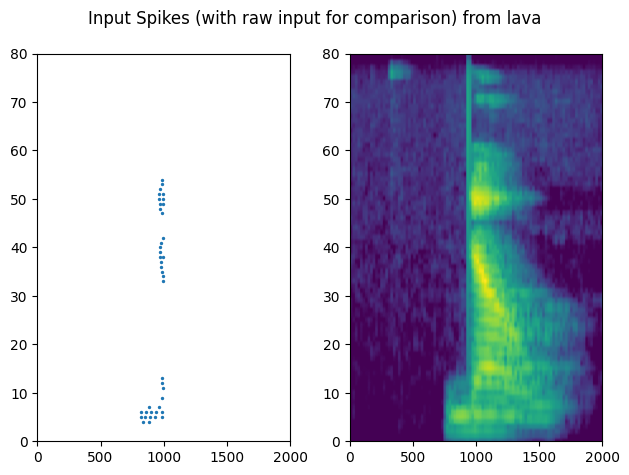

In [10]:
# Input spike activity

input_spikes = monitor_input.get_data()

process = list(input_spikes.keys())[0]
spikes_out = list(input_spikes[process].keys())[0]
input_s = input_spikes[process][spikes_out]

input_single_image = input_s[sample_image_start:sample_image_end]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Input Spikes (with raw input for comparison) from lava')

for i in range(params["NUM_INPUT"]):
    ax1.scatter(np.where(input_single_image[:,i] > 0)[0], 
                np.where(input_single_image[:,i] > 0)[0].shape[0] * [i],
                c = '#1f77b4',
                s = 2)

# no clue why I need to rotate and flip...could be investigated? 
ax2.imshow(np.flipud(np.rot90(the_x[sample_image_start:sample_image_end], 1)), aspect = 'auto')

ax1.set_ylim(0, 80)
ax2.set_ylim(0, 80)
ax1.set_xlim(0, the_x.shape[0] / params["num_samples"])
ax2.set_xlim(0, the_x.shape[0] / params["num_samples"])

fig.tight_layout()

plt.show()

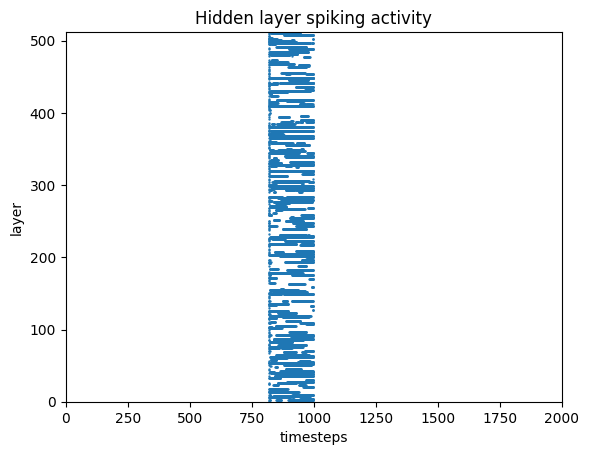

In [11]:
# Hidden layer activity 

hidden_spikes = monitor_hidden.get_data()

process = list(hidden_spikes.keys())[0]
spikes_out = list(hidden_spikes[process].keys())[0]
hidden_s = hidden_spikes[process][spikes_out]

hidden_single_image = hidden_s[sample_image_start:sample_image_end]

for i in range(params["NUM_HIDDEN"]):
    plt.scatter(np.where(hidden_single_image[:,i] > 0)[0], 
                np.where(hidden_single_image[:,i] > 0)[0].shape[0] * [i],
                c = '#1f77b4',
                s = 0.5)

plt.title("Hidden layer spiking activity")
plt.ylim(0, params["NUM_HIDDEN"])
plt.xlim(0, the_x.shape[0] / params["num_samples"])
plt.ylabel("layer")
plt.xlabel("timesteps")
plt.show()

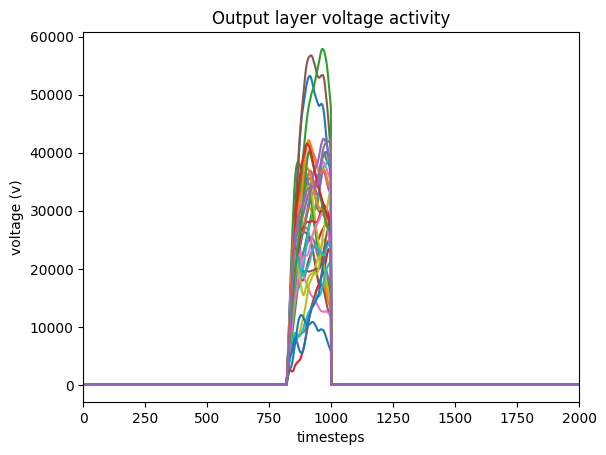

In [12]:
# output voltage activity
# high voltage levels are explained by a mega high threshold, to enable non-spiking
output_voltage = monitor_output.get_data()

process = list(output_voltage.keys())[0]
spikes_out = list(output_voltage[process].keys())[0]
output_v = output_voltage[process][spikes_out]

single_image = output_v[sample_image_start:sample_image_end]

for i in range(params["NUM_OUTPUT"]):
    plt.plot(single_image[:,i])

plt.title("Output layer voltage activity")
plt.ylabel("voltage (v)")
plt.xlabel("timesteps")
plt.xlim(0, the_x.shape[0] / params["num_samples"])
plt.show()